This example is the same as before, but using the $V_{m}$ as the state variable (to avoid the time it takes to filter the spikes). Additionally, we use scikit-learn to compute the capacity.. I also reduced the size of the main network to reduce the memory load..

In [1]:
import nest
import numpy as np
import pylab as pl
from sklearn.linear_model import LinearRegression
from functions import *

# Global parameters
T = 1000  # total number of time steps
dt = 0.1  # simulation resolution

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,
    'print_time': True,
    'local_num_threads': 8})

###
# Input parameters
u_range = [0., 1.]
duration = 10. # [ms]

u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)
input_times = np.arange(dt, T*duration, duration)
input_dt = 1. # for speed

###
# Parameters
nEnc = 1000
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

enc_layer = nest.Create('iaf_neuron', nEnc, {'I_e': J_bias})

step_generator = nest.Create('step_current_generator', nEnc)
amplitudes = np.zeros((nEnc, len(u)))
for n in range(nEnc):
	amplitudes[n, :] = u * tuning[n]
	nest.SetStatus([enc_layer[n]], {'V_m': Vm0[n], 'V_th': thresholds[n]})
	nest.SetStatus([step_generator[n]], {'amplitude_times': input_times,
	                                     'amplitude_values': amplitudes[n]})
	nest.Connect([step_generator[n]], [enc_layer[n]])
    
enc_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': input_dt})
nest.Connect(enc_v, enc_layer)

In [2]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 5000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# device
net_v = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': input_dt})
nest.Connect(net_v, neurons_e)

In [3]:
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

In [4]:
nest.Simulate(T*duration+dt)

In [5]:
time_vector = np.arange(0., T*duration, input_dt) # take 1 sample per step
signal = np.zeros_like(time_vector)
for tt in range(len(input_times)-1):
	signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]
    
enc_activity = nest.GetStatus(enc_v)[0]['events']
net_activity = nest.GetStatus(net_v)[0]['events']

In [7]:
enc_indices = np.sort(np.unique(enc_activity['senders']))
enc_states = np.zeros((nEnc, int(T/dt)))
for idx, i in enumerate(enc_indices):
    enc_states[idx, :] = enc_activity['V_m'][np.where(enc_activity['senders']==i)[0]]
    
net_indices = np.sort(np.unique(net_activity['senders']))
e_states = np.zeros((NE, int(T/dt)))
for idx, i in enumerate(net_indices):
    e_states[idx, :] = net_activity['V_m'][np.where(net_activity['senders']==i)[0]]

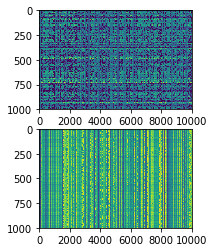

In [8]:
fig = pl.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(enc_states, aspect='auto')
ax3 = fig.add_subplot(223)
ax3.imshow(e_states, aspect='auto')
pl.show()

In [9]:
def compute_capacity(a, y):
	"""
	Compute capacity to reconstruct y based on linearly combining a
	:param a: state matrix (NxT)
	:param y: target output (1xT)
	:return y_hat: estimated signal
    :return capacity: 
    :return error:
	"""
	reg = LinearRegression(n_jobs=-1, fit_intercept=False, normalize=True, copy_X=False).fit(a.T, y)
	y_hat = np.dot(reg.coef_, a)
	return y_hat, 1. - (np.mean((y - y_hat) ** 2) / np.var(y)), np.mean((y - y_hat) ** 2) 

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal)
circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal)

print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

Encoding Layer: 
	- Capacity=0.20258375426018715, MSE=0.058734661774614304
Main Circuit: 
	- Capacity=0.3710899104551698, MSE=0.046323136245848044


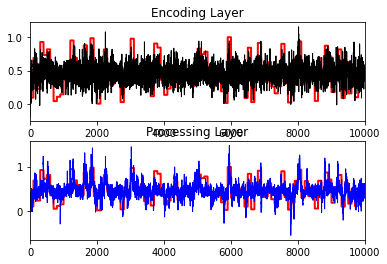

In [10]:
fig = pl.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(time_vector, signal, 'r', linewidth=2)
ax1.plot(time_vector, enc_estimate, 'k', linewidth=1)
ax1.set_xlim([0., T*duration])
ax1.set_title('Encoding Layer')
ax2.plot(time_vector, signal, 'r', linewidth=2)
ax2.plot(time_vector, circ_estimate, 'b', linewidth=1)
ax2.set_xlim([0., T*duration])
ax2.set_title('Processing Layer')
pl.show()

In [11]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] - if != dt (index the time axis)
time_lags = np.arange(0., max_lag, step_lag)
indices = [np.where(idx==time_vector)[0][0] for idx in time_lags]

encoder_capacity = []
circuit_capacity = []

for idx, lag in zip(indices, time_lags):
    
    # shift the target signal
    if idx > 0:
        shifted_signal = signal[:-idx]
    else:
        shifted_signal = signal
    
    # shift the population states
    enc_st = enc_states[:, idx:]
    circ_st = e_states[:, idx:]
    
    # compute capacity
    enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
    circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
    print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))
    
    encoder_capacity.append(enc_capacity)
    circuit_capacity.append(circ_capacity)

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.20258375426018715, MSE=0.058734661774614304
Main Circuit: 
	- Capacity=0.3710899104551698, MSE=0.046323136245848044
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.1994405195485326, MSE=0.05901893068347593
Main Circuit: 
	- Capacity=0.363432711106356, MSE=0.04692908099395091
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.19864152890693398, MSE=0.05913072995935342
Main Circuit: 
	- Capacity=0.38084854699948834, MSE=0.04568601779597678
Lag = 30.0 ms
Encoding Layer: 
	- Capacity=0.19455863139023288, MSE=0.05948525870776846
Main Circuit: 
	- Capacity=0.3723347830220961, MSE=0.0463557364557069
Lag = 40.0 ms
Encoding Layer: 
	- Capacity=0.1992292539388606, MSE=0.059193357670922896
Main Circuit: 
	- Capacity=0.3728179575980789, MSE=0.046361597427589246
Lag = 50.0 ms
Encoding Layer: 
	- Capacity=0.20390008986322716, MSE=0.05890091539963457
Main Circuit: 
	- Capacity=0.3879234164585833, MSE=0.045285611273434896
Lag = 60.0 ms
Encoding Layer: 
	- Capacity=0.

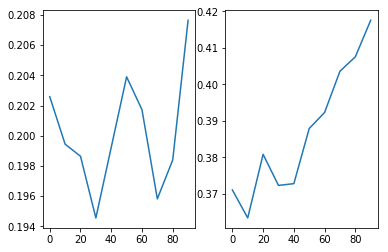

Total capacity (encoder): 20.019375173910735 ms
Total capacity (processor): 38.695027338222474 ms


In [12]:
fig = pl.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time_lags, encoder_capacity)
ax2.plot(time_lags, circuit_capacity)

pl.show()

print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))